Pytania do zadania:  
Gdy zrobiłem najpierw dzielenie na zbiór testowy i treningowy a potem dokonałem normalizacji to osiągnałem mniejsze accuracy niż gdy najpierw znormalizowalem a potem podzieliłem, czy to normalne?

# 0. Logistic Regression

Despite its name, it is implemented as a liear model for classification rather than regression. The logistic regression is also known in the literature as **logit regression**, **maximum-entroopy classification (MaxEnt)** or **the log-linear classifier**. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.  In other words: It is a type of linear model used to estimate the probability of a given innput belonging to a specific class.  

It models probabilities using the logistic funnction (sigmoid function) to predit the possible outcomes of a single trial. The logistic regression ensures that the output is always between 0 and 1, making it suitable for probability estimation. 

Types of logistic regression:  
* binary (e.g) spam vs. not spam
* one-vs.-rest (for multi-class problems where each class is compared separately) 
* multinomial (when multiple classes are considered at once)
* elastic-net regularization.  

Regularization is applied by default, which is common in machine learning but ot in statistics. Another advantage of regularization is that it improves numerical stability. 

The numerical output of the logistic regression, which is the predicted probability, can be used as a classifier by applying a treshhold (by default 0.5) to it. This is how it is implemented in scikit-learn, so it expects a categorical target, making the Logistic Regressionn a classifier. 

# 1. Logistic Regression implementation

## 1.1 Gradient descent

$$\Delta w_j = -\eta(t_j - y_j)f(x_j^Tw_{j-1})[1-f(x_j^Tw_{j-1})]x_j$$ 
gdzie: $$f(s)=\frac{1}{1+e^{-\beta s}}$$

## 1.2 Generating synthetic single-mod datasets

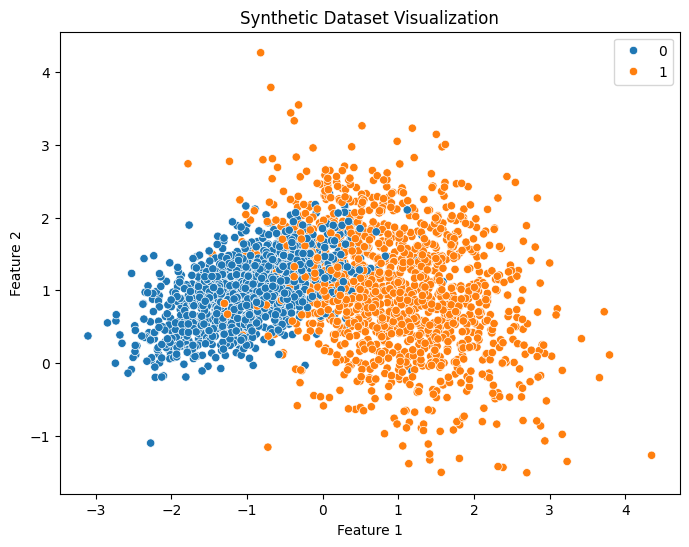

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, auc
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time

RANDOM_STATE = 254687
N_SAMPLES = 2587
N_FEATURES = 2
N_CLASSES = 2

class SyntheticDataset:
    """A class to generate and preprocess synthetic datasets for classification task."""

    def __init__(self, random_state: int, n_samples: int, n_features: int, n_classes: int):
        """
        Initialize the SyntheticDataset class.

        :param random_state: Seed for random number generation.
        :param n_samples: Number of samples to generate.
        :param n_features: Number of features for the dataset.
        :param n_classess: Number of classes for the target variable.
        """
        self.random_state = random_state
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_classes = n_classes 
        self.X = None
        self.y = None

    def generate(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Generate a synthetic dataset using make_classification
        
        :return: A tuple containing the feature matrix (X) and target vector (y)
        """
        self.X, self.y = make_classification(
            n_samples=self.n_samples,
            n_features=self.n_features,
            n_informative=self.n_features,
            n_redundant=0,
            n_clusters_per_class=1, # single-mod means one cluster per class
            random_state=self.random_state
        )
        return self.X, self.y
    
    def normalize(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Normalize the feature matrix (X) and target vector(y) to the range [0,1] 

        :return: A tuple containing the normalized feature matrix (X) and target vector (y)
        """
        if self.X is not None:
            min_x, max_x = self.X.min(), self.X.max()
            self.X = (self.X-min_x)/(max_x-min_x)

        if self.y is not None:    
            min_y, max_y = self.y.min(), self.y.max()
            self.y = (self.y-min_y)/(max_y-min_y)

        return self.X, self.y
    
    def visualize(self): 
        """ Visualize the dataset using a scatter plot"""
        if self.X is not None and self.y is not None:
            plt.figure(figsize=(8,6))
            sns.scatterplot(x=self.X[:,0], y=self.X[:,1], hue=self.y)
            plt.title("Synthetic Dataset Visualization")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.show()
        else:
            print("Dataset not generated yet. Call generate() first.")

    
dataset = SyntheticDataset(RANDOM_STATE, N_SAMPLES, N_FEATURES, N_CLASSES)
X, y = dataset.generate() # X is size of (n_samples x n_features) and y is size of (n_samples,) 
dataset.visualize()

## 1.3 Normalization of the dataset and splitting it into training and test sets

In [2]:
# Normalization of datasets 
X_norm, y_norm = dataset.normalize()

# Dividing dataset on a trening set and test set 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=RANDOM_STATE) # 80% training set, 20% test set

## 1.4 Cost function  
Log loss also known as logistic loss or cross-entropy loss, the log loss measures the performance of a classification model by penalizing incorrect classifications.  
$$J(\mathbf{w}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$  
where:  

N is number of samples  
$y_i$ is true label (0 or 1) for the i-th sample  
$\hat{y_i}$ is the predicted probability (output of the sigmoid function) for the i-th sample  

Gradient of Cross-Entropy Loss:
$$\nabla J(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i) \mathbf{x}_i$$  
The weights are updated using the gradient descent formula:  
$$\mathbf{w}_{\text{new}} = \mathbf{w}_{\text{old}} - \eta \nabla J(\mathbf{w})$$
where $\eta$ is learning_rate

In [3]:

class LogisticRegressionOwn:
    """
    Implemantation of logistic regression with gradient descent for binary classification.

    Parameters:
        :learning_rate (float): The learning rate for gradient descent. Default is 0.1
        :iterations (int): The maximum number of iterations for gradient descent. Default is 1000
        :error (float): The error threshold for early stopping. Default is 1e-6.
    """

    def __init__(self, learning_rate: float = 0.1, iterations: int = 1000, error: float = 1e-6):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.error = error
        self.scale_parameter = None # beta in the sigmoid function
        self.weights = None
    
    def _sigmoid_function(self, s: np.ndarray, scale_parameter: float = 1.0) -> np.ndarray: 
        """
        Compute the sigmoid function.

        The sigmoid function maps any real-valued number into the range [0,1]
        
        Parameters:
            s (np.ndarray): The input to the sigmoid function. 
            scale_parameter (float): Determines the steepness of the sigmoid curve. Default is 1.0

        Notes:
            scale parameter = beta, it determines how sharply the function transions from 0 to 1
            when scale_param > 1 the function becomes steeper, meaning small changes in input lead to more abrupt probability shifts
            when scale_param = 1, default, standard sigmoid function
            when scale_param (0,1), the function becomes more gradual, resulting is a smoother trasinstion  
        
        Returns:
            np.ndarray: The output fo the sigmoid function.
        """
        self.scale_parameter = scale_parameter
        return 1/(1 + np.exp(-self.scale_parameter * s))
    
    def _cross_entropy_lost_cost_function(self, y: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Compute the cross entropy loss.

        Parameters:
            y (np.ndarray): The true labels.
            y_pred (np.ndarray): The predicted probabilities

        Returns:
            float: The cross-entropy loss

        Notes: 
            We have to avoid situation in which there will be log(0) thats why we adding a small epsilon
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon) # np.clip ensures that all values in the array fall within the given minimum and maximum bounds. 
        # Values below the minimum are set to the minimum, and values above the maximum are set to the maximum
        # syntax np.clip(array, min_value, max_value)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Train the logistic regression model using gradient descent.

        Parameters:
            X (np.ndarray): the feature matrix of shape (n_samples, n_features)
            y (np.ndarray): The target vector of shape (n_samples, )
        """

        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples")
        
        # Initialize weights
        self.weights = np.zeros(X.shape[1])

        # Starting timer
        start_time = time.time()

        # Gradient descent
        for i in range(self.iterations):
        
            # Computing sigmoid 
            sigmoid_output = self._sigmoid_function(np.dot(X, self.weights)) # sigmoid output is also 'y_pred' 

            # Compute error and gradient
            error = sigmoid_output - y # y_pred - y
            gradient = np.dot(X.T, error) / len(X)
            delta_w = -self.learning_rate * gradient
            self.weights += delta_w

            # Compute cost
            cost = self._cross_entropy_lost_cost_function(y, sigmoid_output)
            
            # Early stopping
            if abs(cost) < self.error:
                print(f"Stopping early at iteration {i} because cost: {cost} is smaller than error threshold {self.error}")
        
        # End time counter
        end_time = time.time() 
        self.training_time = end_time - start_time # Store training time
        print(f"Training completed in {self.training_time:.4f} seconds.")

    def predict_binary_output(self, X: np.ndarray) -> np.ndarray:
        """
        Predict binary labels for the input data/

        Parameters:
            X (np.ndarray): The feature matrix of shape (n_samples. n_features).

        Returns:
            np.ndarray: The predicted binary labels of shape (n_samples,)
        """
        # Compute the linear combination of inputs and weights
        linear_output = np.dot(X, self.weights)

        # Apply the sigmoid function to get probabilites 
        y_pred = self._sigmoid_function(linear_output)
        return (y_pred >= 0.5).astype(int) # Convert probabilities to binary predictions 
    
    def predict_probability_output(self, X: np.ndarray) -> np.ndarray:
        """
        Predict probabilities for the input data.

        Parameters:
            X (np.ndarray): The feature matrix of shape (n_samples, n_features)
    
        Returns:
            np.ndarray: The predicted probabilities of shape (n_samples,)
        """
        linear_output = np.dot(X, self.weights)
        y_pred = self._sigmoid_function(linear_output)
        return y_pred


logistic_regression_solver = LogisticRegressionOwn()
logistic_regression_solver.fit(X_train, y_train)
y_pred = logistic_regression_solver.predict_binary_output(X_test)
y_pred_probability = logistic_regression_solver.predict_probability_output(X_test)


Training completed in 0.0787 seconds.


Accuracy: 0.89, Sensivity: 0.90, Specifity: 0.88


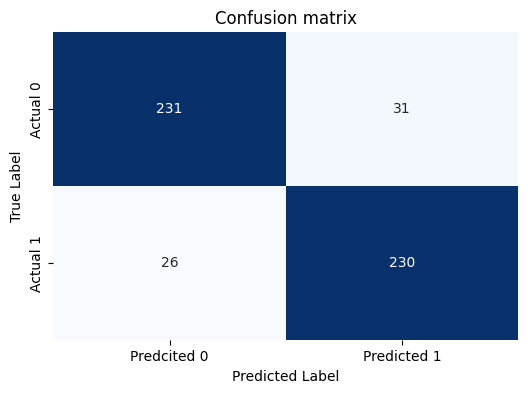

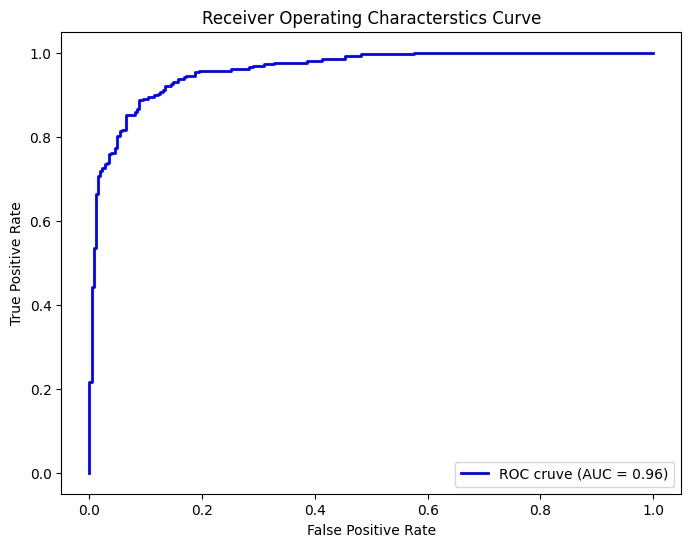

In [4]:
class ResultsAnalyzes:
    """ 
    A class to analyze and visualize the results of a binary classification model.

    Parameters:
        target (np.ndarray): The true labels.
        prediction (np.ndarray): The predicted labels.
    """

    def __init__(self, target: np.ndarray, prediction: np.ndarray):
        self.target = target
        self.prediction = prediction
        self._accuracy = None # Private atribute
        self._sensitivity = None
        self._specificity = None

    def confusion_matrix(self):
        """ Compute and plot the confusion matrix """
        cm = confusion_matrix(self.target, self.prediction)

        # Plot the confusion matrix using Seaborn
        plt.figure(figsize=(6,4))
        sns.heatmap(
            cm, 
            annot=True, # Displays the value in each cell
            fmt="d", # Format the values as integers
            cmap="Blues", # uses a blue color palette 
            cbar=False, # Hide the color bar
            xticklabels=["Predcited 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"]
        )
        
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion matrix")
        plt.show()

    @property 
    def accuracy(self) -> float:
        """ 
        Compute the accuracy of the predictions.
        
        Notes:
            Tells how many samples were well classified from all samples
        """
        return accuracy_score(self.target, self.prediction) 

    @property
    def sensitivity(self) -> float: 
        """ 
        Compute the sensivitty (recall) of the predictions. Sensitivity (Recall) = TP / (TP + FN) 
        
        Notes:
            Tell how many samples were predicted as True Positive from all Acutal Positive
        """
        
        return recall_score(self.target, self.prediction)

    @property
    def specificity(self) -> float: 
        """
        Compute the specificity of the predictions.  Specificity = TN / (TN + FP)

        Notes:
            Tell how many samples were predicted as True Negatives from all Acutal Negative
        """
        
        cm = confusion_matrix(self.target, self.prediction)
        tn, fp, fn, tp = cm.ravel() # ravel function in numpy is used to faltten a multi-dimensional array into a 1-dimensional array. It returns a contiguous flattened array, meaning it 
        # collapses the array into a single dimension while maintaining the order of the elements 
        specificity = tn / (tn + fp)
        return specificity

    def show_results(self):
        """ Display the accuracy, sensitivity and specificity of the predictions"""
        #self.accuracy = self._accuracy()
        #self.sensitivity = self._sensitivity()
        #self.specificity = self._specificity()
        print(f"Accuracy: {self.accuracy:.2f}, Sensivity: {self.sensitivity:.2f}, Specifity: {self.specificity:.2f}")

    def plot_ROC_curve(self, y_prediction_probability: np.ndarray):
        """
        Plot the Receiver Operaint Characteristic (ROC) curve.
        
        Parameters:
            y_prediction_probability (np.ndarray): The predicted probabilities for the positive class.
        """
        # Compute ORC curve and AUC
        fpr, tpr, thresholds = roc_curve(self.target, y_prediction_probability) # stands for False Positive Rate (1 - Specificity)  and True Positive Rate (Sensitivity)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC cruve (AUC = {roc_auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characterstics Curve")
        plt.legend(loc="lower right")
        plt.show()

        def plot_decision_boundary(self, X: np.ndarray, y: np.ndarray):
            """
            Plot the decision boundary for a trained model.
            
            Parameters:
                X (np.ndarray): The feature matrix of shape (n_samples,n_features)
                y (np.ndarray): The target vector of shape (n_samples,).
            """

            if X.shape[1] != 2:
                raise ValueError("Decision boundary plotting is only supported for 2D feature spaces.")
            
            # Create a grid of points covering the feature space
            x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1 # Frist feature
            y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1 # Second feature

             

results = ResultsAnalyzes(y_test, y_pred)
results.show_results()

results.confusion_matrix()
results.plot_ROC_curve(y_pred_probability)


## 1.5 Model from sklearn  

Training completed in 0.0084 seconds.
Accuracy: 0.89, Sensivity: 0.90, Specifity: 0.88


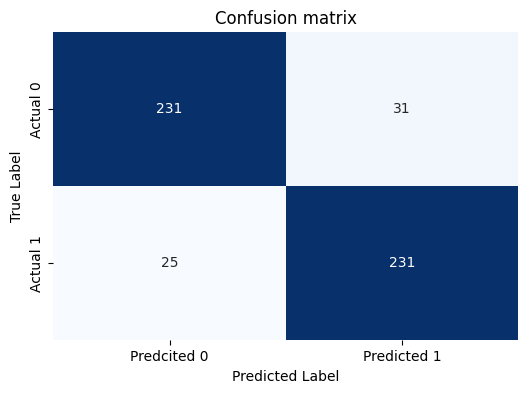

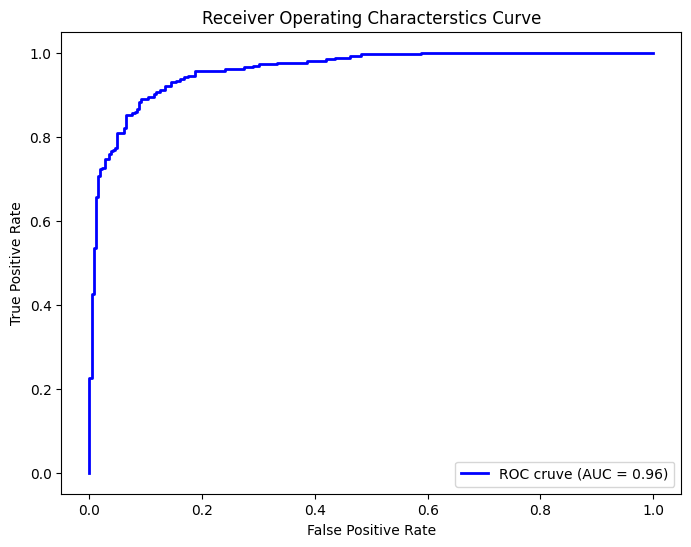

In [5]:
logistic_regression_sklearn_solver = LogisticRegression()
start_time = time.time() # Start time
logistic_regression_sklearn_solver.fit(X_train, y_train)
end_time = time.time() # End time
time_complexity = end_time - start_time
print(f"Training completed in {time_complexity:.4f} seconds.")
sklearn_pred = logistic_regression_sklearn_solver.predict(X_test)
sklearn_pred_probability = logistic_regression_sklearn_solver.predict_proba(X_test)[:,1] # Probability that sample belongs to class: "1",w hen we talk about binary classes

results_sklearn = ResultsAnalyzes(y_test, sklearn_pred)
results_sklearn.show_results()
results_sklearn.confusion_matrix()
results_sklearn.plot_ROC_curve(sklearn_pred_probability)